In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gillespie

## Setup starting states and reactions parameters

The parameters are taken from the following paper:

>[Bacterial Persistence: A Model of Survival in Changing Environments](https://academic.oup.com/genetics/article-abstract/169/4/1807/6059501)

In [13]:
# number of molecules (individuals), in the order:
# wt, wt_persister, mut, persister
reag_quant = [50_000, 0, 50_000, 0]

# Vector updates. In the order:
# growth wt
# growth wt persister
# switch wt to wt persister
# switch wt persister to wt
# growth mut
# growth mut persister
# switch mut to mut persister
# switch mut persister to mut
state_change_vect_normal = [[+1, 0, 0, 0],
                            [0, +1, 0, 0],
                            [-1, +1, 0, 0],
                            [+1, -1, 0, 0],
                            [0, 0, +1, 0],
                            [0, 0, 0, +1],
                            [0, 0, -1, +1],
                            [0, 0, +1, -1]]

state_change_vect_abt = [[-1, 0, 0, 0],
                         [0, -1, 0, 0],
                         [-1, +1, 0, 0],
                         [+1, -1, 0, 0],
                         [0, 0, -1, 0],
                         [0, 0, 0, -1],
                         [0, 0, -1, +1],
                         [0, 0, +1, -1]]


# combinatorics functions (KEEP THIS POSITIVE, DO NOT INTRODUCE MINUS (-))
combinatorics_normal = [lambda a,b,c,d : (2 * a),
                        lambda a,b,c,d : (0.002 * b),
                        lambda a,b,c,d : ((1.2*1e-6)*a),
                        lambda a,b,c,d : (0.1*b),
                        lambda a,b,c,d : (2 * c),
                        lambda a,b,c,d : (0.2 * d),
                        lambda a,b,c,d : (0.001 * c),
                        lambda a,b,c,d : (1e-4 * d)]

combinatorics_abt = [lambda a,b,c,d : (4 * a),
                     lambda a,b,c,d : (0.4 * b),
                     lambda a,b,c,d : ((1.2*1e-6)*a),
                     lambda a,b,c,d : (0.1*b),
                     lambda a,b,c,d : (4 * c),
                     lambda a,b,c,d : (0.4 * d),
                     lambda a,b,c,d : (0.001 * c),
                     lambda a,b,c,d : (1e-4 * d)]


## Dict to be passed to our class

combinatorics = {'normal': combinatorics_normal,
                 'abt' : combinatorics_abt}

oscillation_interval = {'normal' : 20,
                        'abt': 2.5}

state_change_vect = {'normal': state_change_vect_normal,
                     'abt': state_change_vect_abt}

## instantiate and run class with appropriate arguments

In [14]:

a = gillespie.gillespie_dynamic.gillespie_dynamic(reagent_quantity=reag_quant, 
                                                  state_change_vectors=state_change_vect,
                                                  combinatorics=combinatorics,
                                                  max_time= 200,
                                                  # max_iteration = 1000,
                                                  rescale=110_000,
                                                  Ni=100_000,
                                                  oscillation_interval = oscillation_interval,
                                                  stop_condition="time",
                                                  start_with='normal')

# result_dict[epoch] = [a.timestep_list, a.molecular_species_history]
# plt.plot(range(a.actual_iteration+1),[y[0] for y in a.molecular_species_history])
# plt.plot([x for x in a.timestep_list],[y[0] for y in a.molecular_species_history])

Actual state is: normal, actual iteration is: 0, simulation time is 0, real time is: Thu Jan  8 21:45:25 2026.
Actual state is: normal, actual iteration is: 1000000, simulation time is 4.763946238577638, real time is: Thu Jan  8 21:45:53 2026.
5.000001084447055
2.522382895190687
5.000013403552217
2.5404795989932314


In [15]:
# segment to track switches
where_pos = []
for tim in tqdm(a.timestep_list):
    start_bool = tim > np.array(a.time_tracker['normal']['start'])
    end_bool = tim < np.array(a.time_tracker['normal']['end'])
    if any(start_bool == end_bool):
        where_pos.append(True)
    else:
        where_pos.append(False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1248791/1248791 [00:06<00:00, 200021.04it/s]


CPU times: user 1.82 s, sys: 135 ms, total: 1.95 s
Wall time: 2.25 s


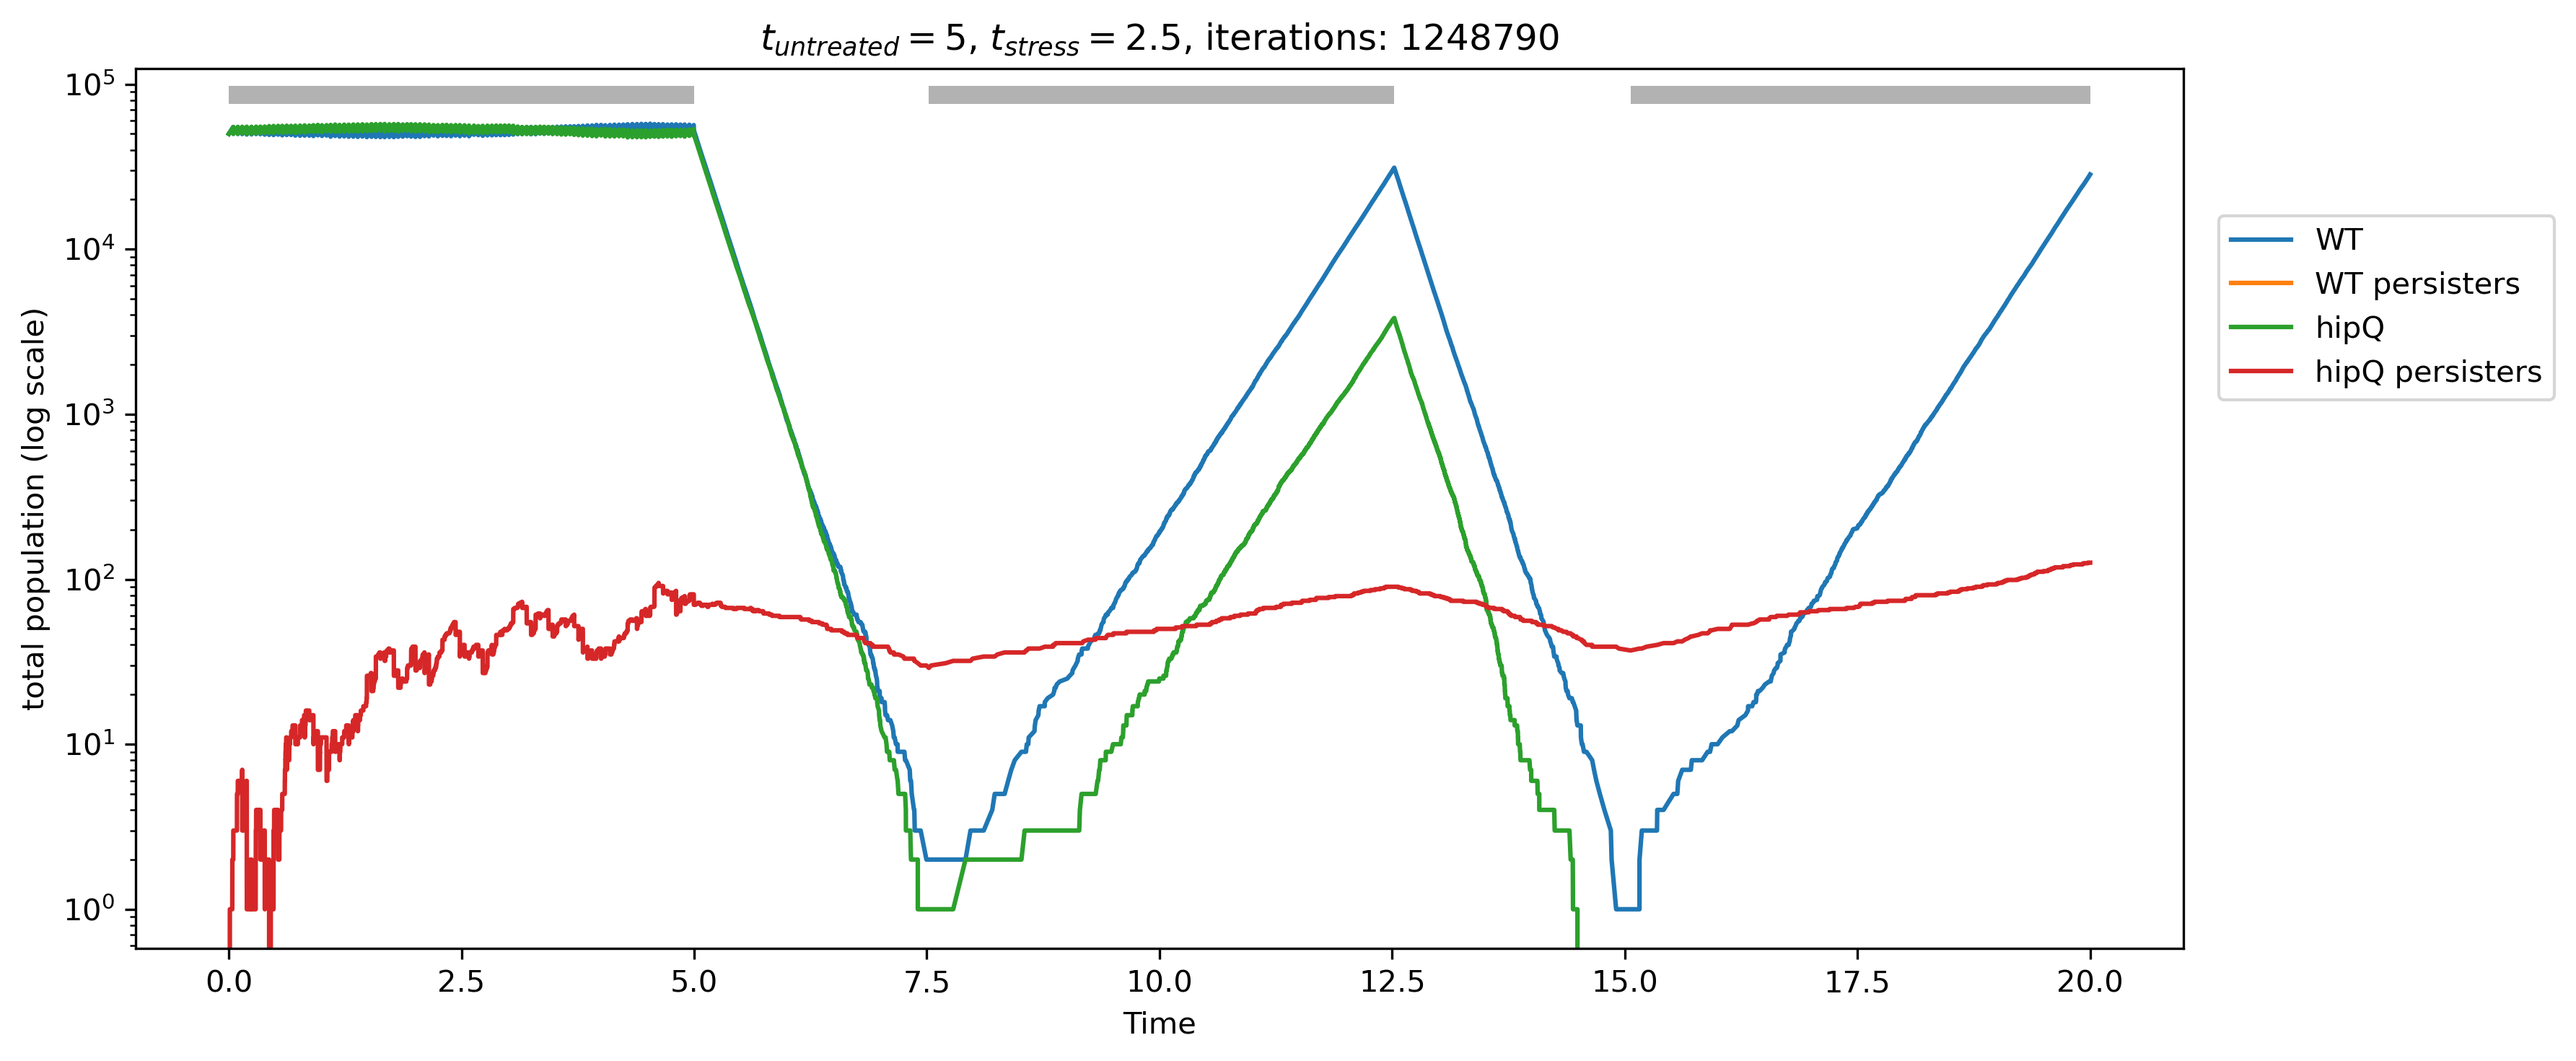

In [17]:
%%time

# out_path = ""
# img_name = "image.png"

fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(a.timestep_list, [y[0] for y in a.molecular_species_history], label='WT')
ax.plot(a.timestep_list, [y[1] for y in a.molecular_species_history], label='WT persisters')
ax.plot(a.timestep_list, [y[2] for y in a.molecular_species_history], label='hipQ')
ax.plot(a.timestep_list, [y[3] for y in a.molecular_species_history], label='hipQ persisters')
ax.set_yscale('log')

ax.set_title(
    rf"$t_{{untreated}} = {oscillation_interval['normal']}$, "
    rf"$t_{{stress}} = {oscillation_interval['abt']}$"
    + f", iterations: {a.actual_iteration}"
)
ax.set_xlabel("Time")
ax.set_ylabel("total population (log scale)")
ax.legend(bbox_to_anchor=(1.01, 0.85))

# Draw state intervals (e.g. shade 'normal')
starts = a.time_tracker["normal"]["start"]
ends   = a.time_tracker["normal"]["end"]

# add space on top
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.25)

for s, e in zip(starts, ends):
    ax.axvspan(s, e, ymin=0.96, ymax=0.98, color="grey", alpha=0.6, lw=0)

fig.tight_layout()
# plt.savefig(os.path.join(out_path, img_name), dpi=300)